## Analysis of shifts in a DFE of introgressed alleles over time

Analyses of trajectories of Neanderthal ancestry over time show an abrupt removal of much of the Neanderthal shortly (< 50 generations?) after the Neanderthal admixture. After this, the levels of Neanderthal ancestry in a population almost doesn't change at all.

One of the possible reasons for the quick flattening of the Nea. ancestry curve is the fact that selection was not able to remove introgressed Neanderthal alleles because the effective population size $N_e$ wasn't large enough.

In this notebook I'm trying to find out if there are some interesting patterns in the distribution of selection coefficients (_s_) of introgressed alleles over time that could reveal something about the process of selection against introgressed Neanderthal mutations.

I considered three models (example in the plot bellow):

* classic Gravel et al. demographic model
* model of a constant $N_e = 10000$
* model of an initial linear growth until $N_e = 10000$ followed by a period exponential growth

In [1]:
suppressPackageStartupMessages(library(tidyverse))
suppressPackageStartupMessages(library(lazyeval))
suppressPackageStartupMessages(library(reshape2))

suppressPackageStartupMessages(source("../R/process_slim_output.R"))

Conflicts with tidy packages ---------------------------------------------------


In [2]:
traject_dir <- "../simulations/different_models"

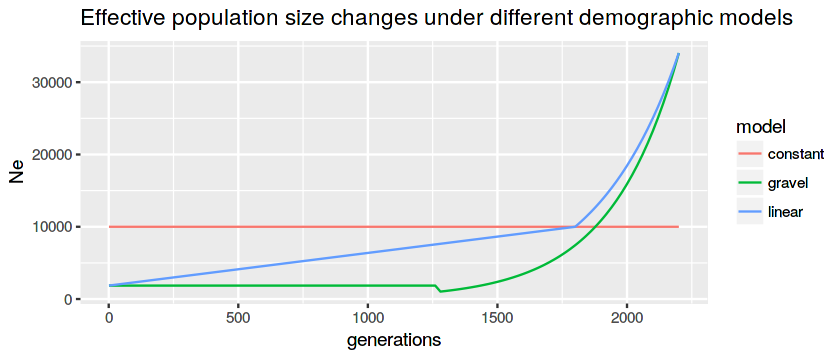

In [6]:
options(repr.plot.width=7, repr.plot.height=3)

# the custom SLiM output format includes a column with a Ne at each time-point
# this simply plots the values in this column for different simulation replicates
rbind(
    read.table(file.path(traject_dir, "constant__h_0.5__init_nea_0.1__rep_1__exonic_sites.txt"), header=TRUE) %>% mutate(model="constant"),
    read.table(file.path(traject_dir, "gravel__h_0.5__init_nea_0.1__rep_1__exonic_sites.txt"), header=TRUE)   %>% mutate(model="gravel"),
    read.table(file.path(traject_dir, "linear__h_0.5__init_nea_0.1__rep_1__exonic_sites.txt"), header=TRUE)   %>% mutate(model="linear")
) %>%
ggplot(aes(gen, Ne, color=model)) +
    geom_line() +
    labs(title="Effective population size changes under different demographic models",
         x="generations")

## Comparison of Neanderthal- and modern human-specific deleterious variants

Just a sanity check, I compared the DFE of Neanderthal-specific and modern-human specific mutations accumulated since the split between these two lineages (500 kya).

In [43]:
files <- c("../simulations/exome_and_sites__h_1.0__seed_739695224962.txt",
        "../simulations/exome_and_sites__h_0.9__seed_5002203582499.txt",
        "../simulations/exome_and_sites__h_0.5__seed_6977220333793.txt",
        "../simulations/exome_and_sites__h_0.1__seed_1039995113621.txt",
        "../simulations/exome_and_sites__h_0.0__seed_6127248992875.txt")

all_mutations <- lapply(files, function(f) {
    slim_file <- read_slim_file(f)

    nea_mut <- read_mutations(slim_file, "m0", "p2") %>% mutate(count=freq, freq=count / (2 * 1000), pop_origin="Nea")
    mh_mut <- read_mutations(slim_file, "m0", "p1", t=50000) %>% mutate(count=freq, freq=count / (2 * (10000 + 1861)), pop_origin="AMH")

    rbind(mh_mut, nea_mut)
}) %>% bind_rows

Warning message:
"Removed 86 rows containing non-finite values (stat_ydensity)."Warning message in density.default(x, weights = w, bw = bw, adjust = adjust, kernel = kernel, :
"sum(weights) != 1  -- will not get true density"Warning message in density.default(x, weights = w, bw = bw, adjust = adjust, kernel = kernel, :
"sum(weights) != 1  -- will not get true density"Warning message in density.default(x, weights = w, bw = bw, adjust = adjust, kernel = kernel, :
"sum(weights) != 1  -- will not get true density"Warning message in density.default(x, weights = w, bw = bw, adjust = adjust, kernel = kernel, :
"sum(weights) != 1  -- will not get true density"Warning message in density.default(x, weights = w, bw = bw, adjust = adjust, kernel = kernel, :
"sum(weights) != 1  -- will not get true density"Warning message in density.default(x, weights = w, bw = bw, adjust = adjust, kernel = kernel, :
"sum(weights) != 1  -- will not get true density"Warning message in density.default(x, weights = w,

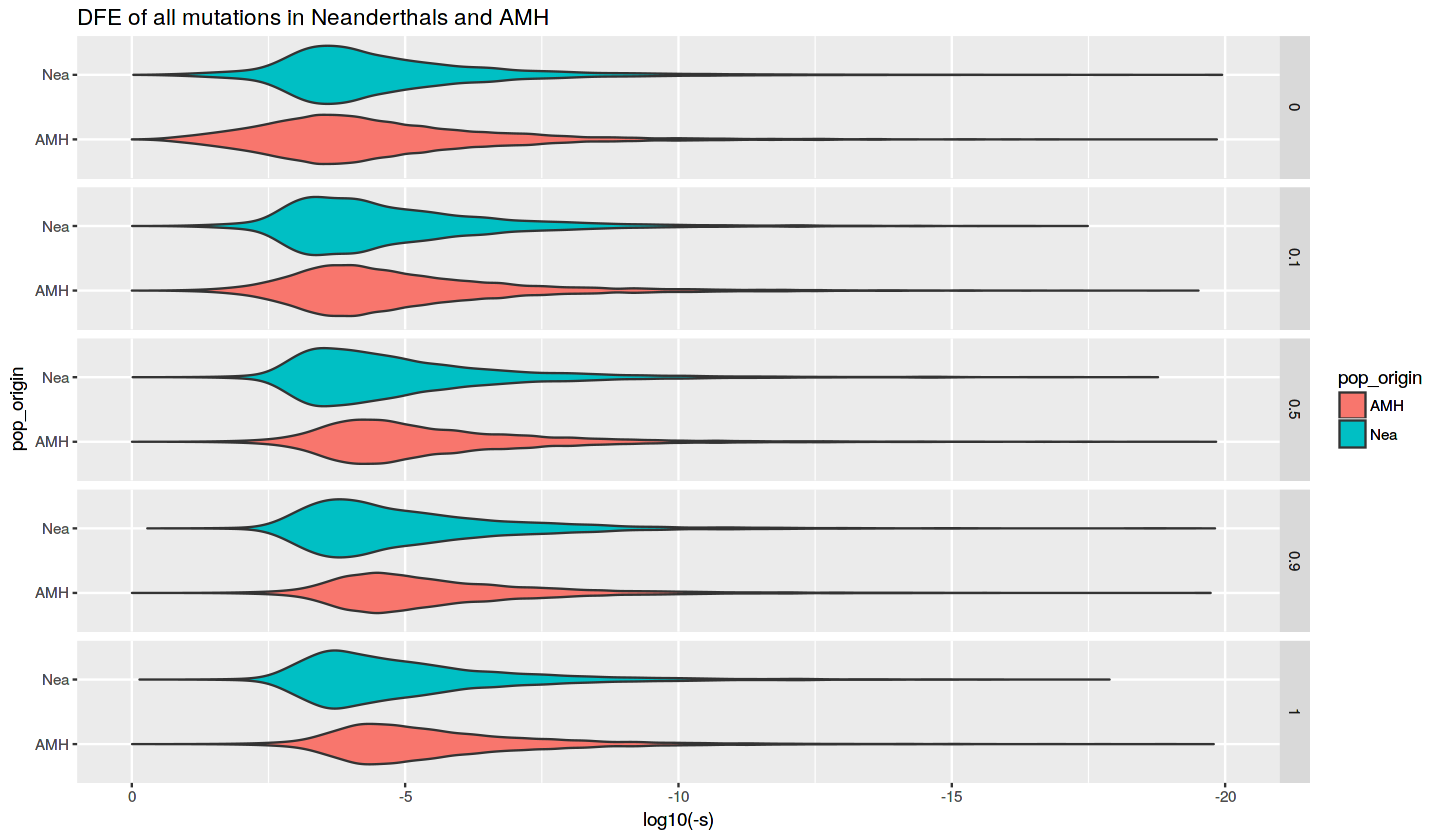

In [21]:
options(repr.plot.width=12, repr.plot.height=7)

ggplot(mutations, aes(pop_origin, log10(-s), fill=pop_origin)) +
    geom_violin(aes(weight=freq)) +
    geom_hline(yintercept=log10(1/(2 * c(1000, 10000))), color=c("green", "red")) +
    coord_flip() +
    facet_grid(h ~ .) +
    ylim(0, -20) +
    labs(title="DFE of all mutations in Neanderthals and AMH ")

In [42]:
group_by(mutations, pop_origin, )

mut_id,run_id,mut_type,pos,s,h,pop_origin,gen_origin,freq,model,kind,gen
68108,506330437,m0,55088618,-3.43958e-06,1,p1,50000,0.19675,constant,AMH,1
71016,506370528,m0,29736991,-1.11711e-04,1,p1,50003,0.13985,constant,AMH,1
70691,506438601,m0,2631549,-3.04107e-05,1,p1,50009,0.30510,constant,AMH,1
70748,506484648,m0,7406655,-1.27764e-07,1,p1,50014,0.23720,constant,AMH,1
77089,506512010,m0,44332432,-8.48508e-05,1,p1,50016,0.08315,constant,AMH,1
65517,506577122,m0,43429151,-1.06059e-06,1,p1,50022,0.46540,constant,AMH,1


### Load the SLiM simulation output files for each model at different timepoints

This is a lot of data to parse (237 Gb for all simulation scenarios), so we're going to do this in parallel.

In [22]:
library(parallel)

In [23]:
(gens <- c(1:30, seq(100, 2200, 300)))         # generations at which we dumped SLiM mutations
(models <- c("constant", "linear", "gravel"))  # demographic models simulated
(dominances <- c("1.0", "0.9", "0.5", "0.1", "0.0"))         # dominance coefficients simulated

[1]    1    2    3    4    5    6    7    8    9   10   11   12   13   14   15
[16]   16   17   18   19   20   21   22   23   24   25   26   27   28   29   30
[31]  100  400  700 1000 1300 1600 1900 2200

[1] "constant" "linear"   "gravel"

[1] "1.0" "0.9" "0.5" "0.1" "0.0"

In [24]:
combinations <- expand.grid(gen=gens, model=models, h=dominances)

In [25]:
if (!file.exists("../tmp/deleterious_mutations.Rds")) {

mutations_df_list <-
    mclapply(
        1 : nrow(combinations),
        function(i) {
            model <- combinations[i, "model"]
            gen <- as.integer(combinations[i, "gen"])
            h <- combinations[i, "h"]

            # load the whole SLiM output file first
            slim_file <- read_slim_file(file.path(traject_dir,
                                                  paste0(model,
                                                         "__h_", h,
                                                         "__init_nea_0.1__rep_1__dump_gen_",
                                                         gen,
                                                         ".txt")))

            # get the Ne of modern humans in this generation
            N <- filter(read_populations(slim_file), pop_id == "p3")$pop_size

            # get info about the introgressed deleterious Nea. mutations
            # (anotate with the model, population origin, generation and frequency)
            nea_mut <-
                read_mutations(slim_file, "m0", "p2") %>%
                mutate(model=model, kind="Nea", gen=gen, freq=freq / (2 * N))

            # get info about the the "control" modern-human deleterious mutations
            # (anotate with the model, population origin, generation and frequency)
            control_mut <-
                read_mutations(slim_file, "m0", "p1", t=50000) %>%
                mutate(model=model, kind="AMH", gen=gen, freq=freq / (2 * N))

            # join both into a single dataframe and return it
            bind_rows(control_mut, nea_mut)
        },
        mc.cores=50 #detectCores()
    )
    
    mutations <- bind_rows(mutations_df_list) %>% mutate(gen=factor(gen))
    saveRDS(mutations, "../tmp/deleterious_mutations.Rds")
    
} else {
    
mutations <- readRDS("../tmp/deleterious_mutations.Rds")

}

## Distribution of _s_ over time weighted by the allele frequency (log-scale)

In [26]:
options(repr.plot.width=15, repr.plot.height=13)

Warning message in rq.fit.br(wx, wy, tau = tau, ...):
"Solution may be nonunique"

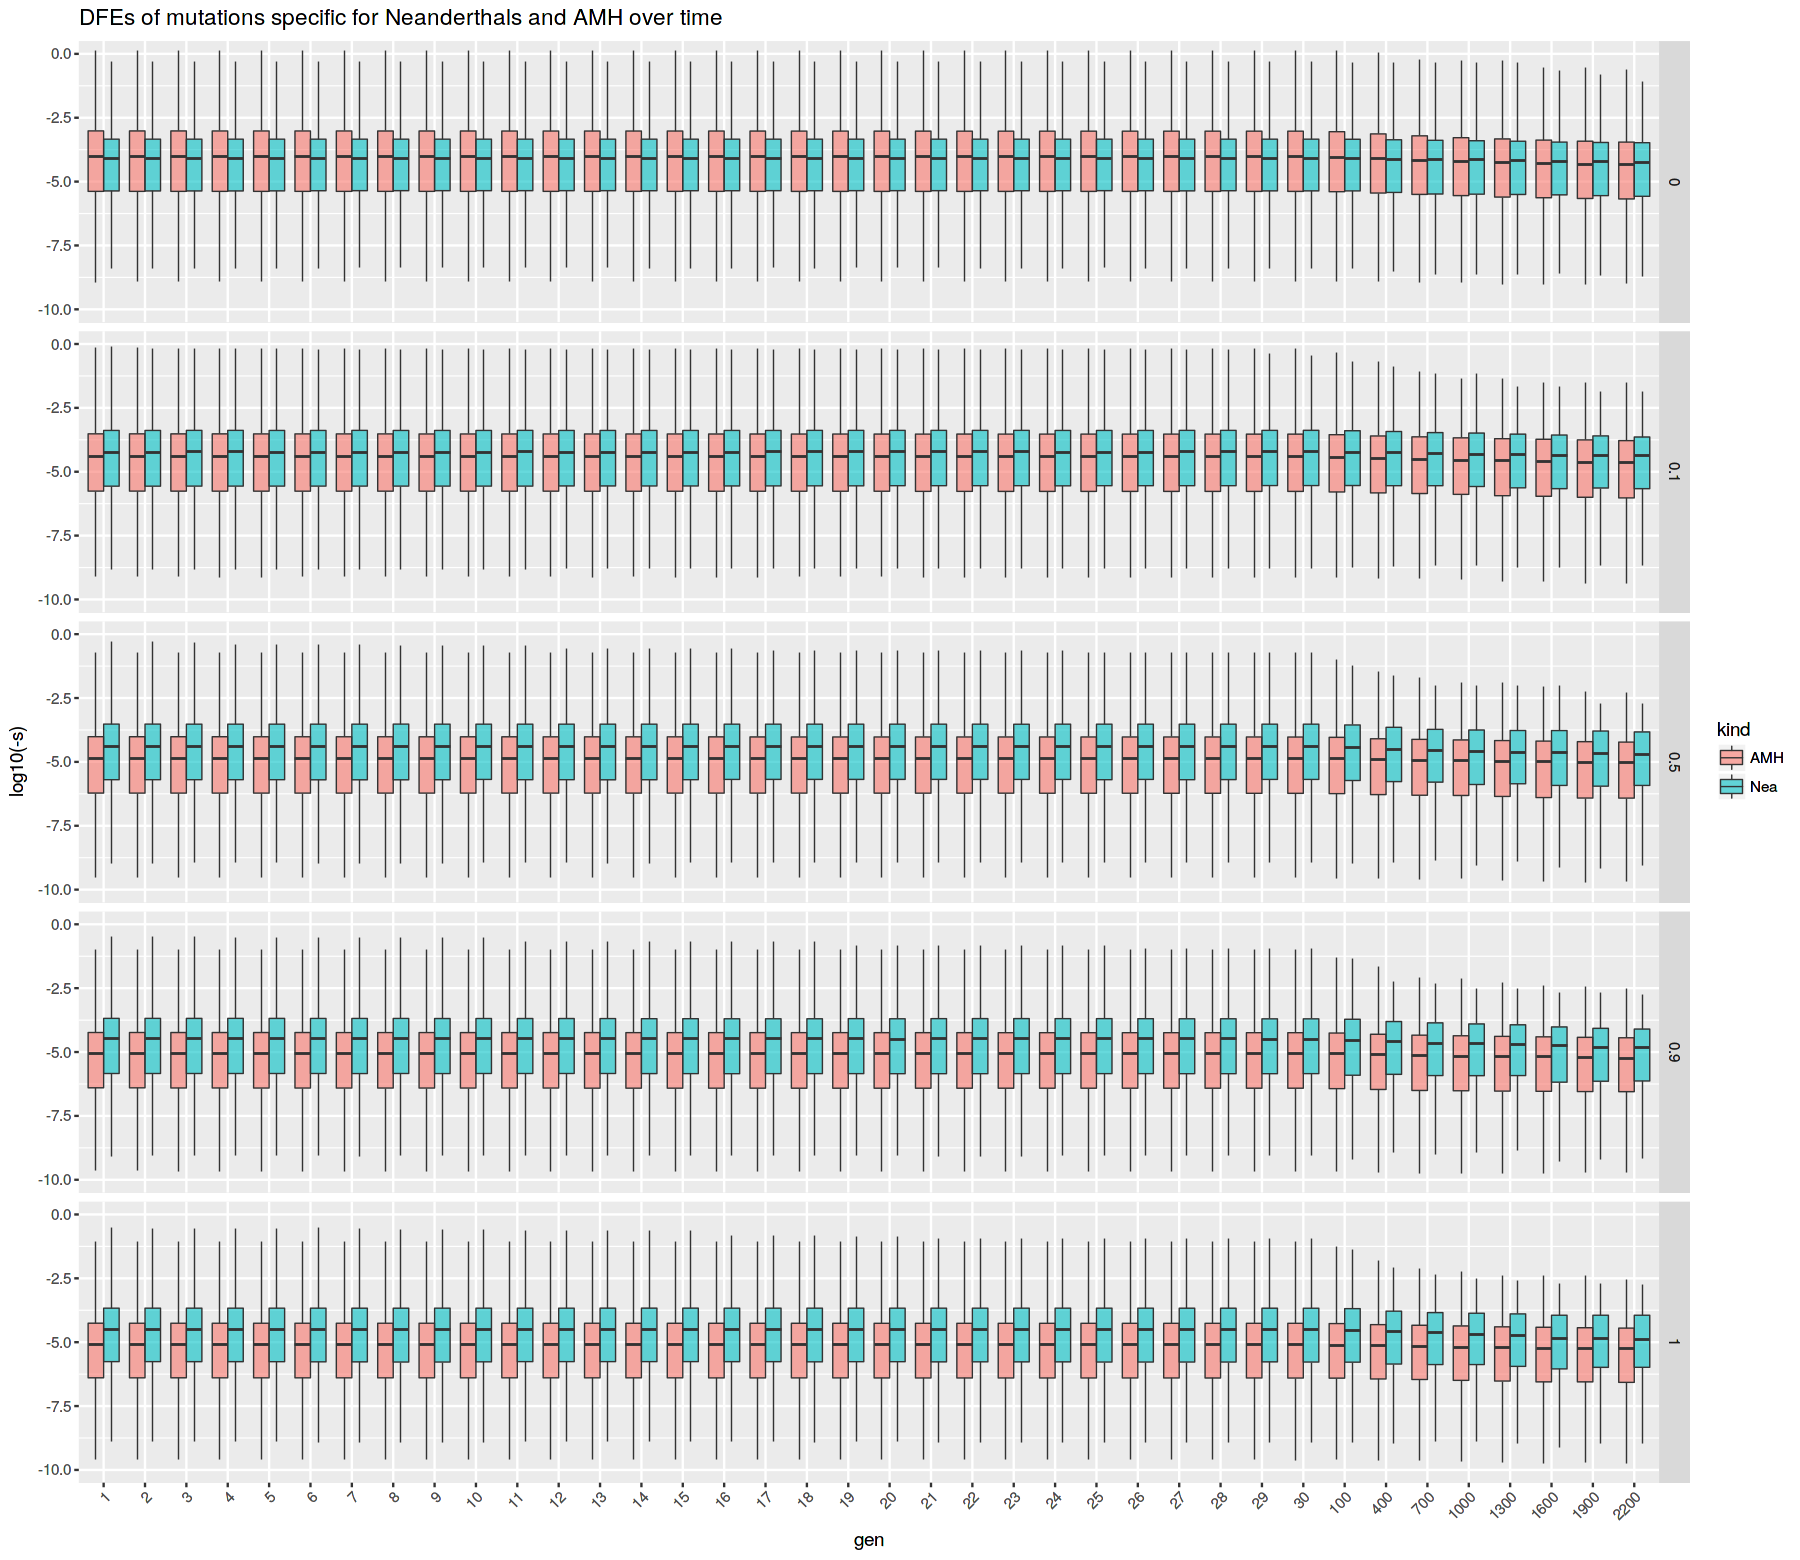

In [15]:
filter(mutations, model == "constant") %>%
ggplot() +
    geom_boxplot(aes(x=gen, y=log10(-s), fill=kind, weight=freq), alpha=0.6, outlier.shape=NA, size=0.3) +
    facet_grid(h ~ .) +
    coord_cartesian(ylim=c(0, -10)) +
    labs(title="DFEs of mutations specific for Neanderthals and AMH over time") +
    theme(axis.text.x = element_text(angle=45, hjust=1))

### Same data as above, just looking at the first two generations and the last one side-by-side

In [34]:
options(repr.plot.width=12, repr.plot.height=8)

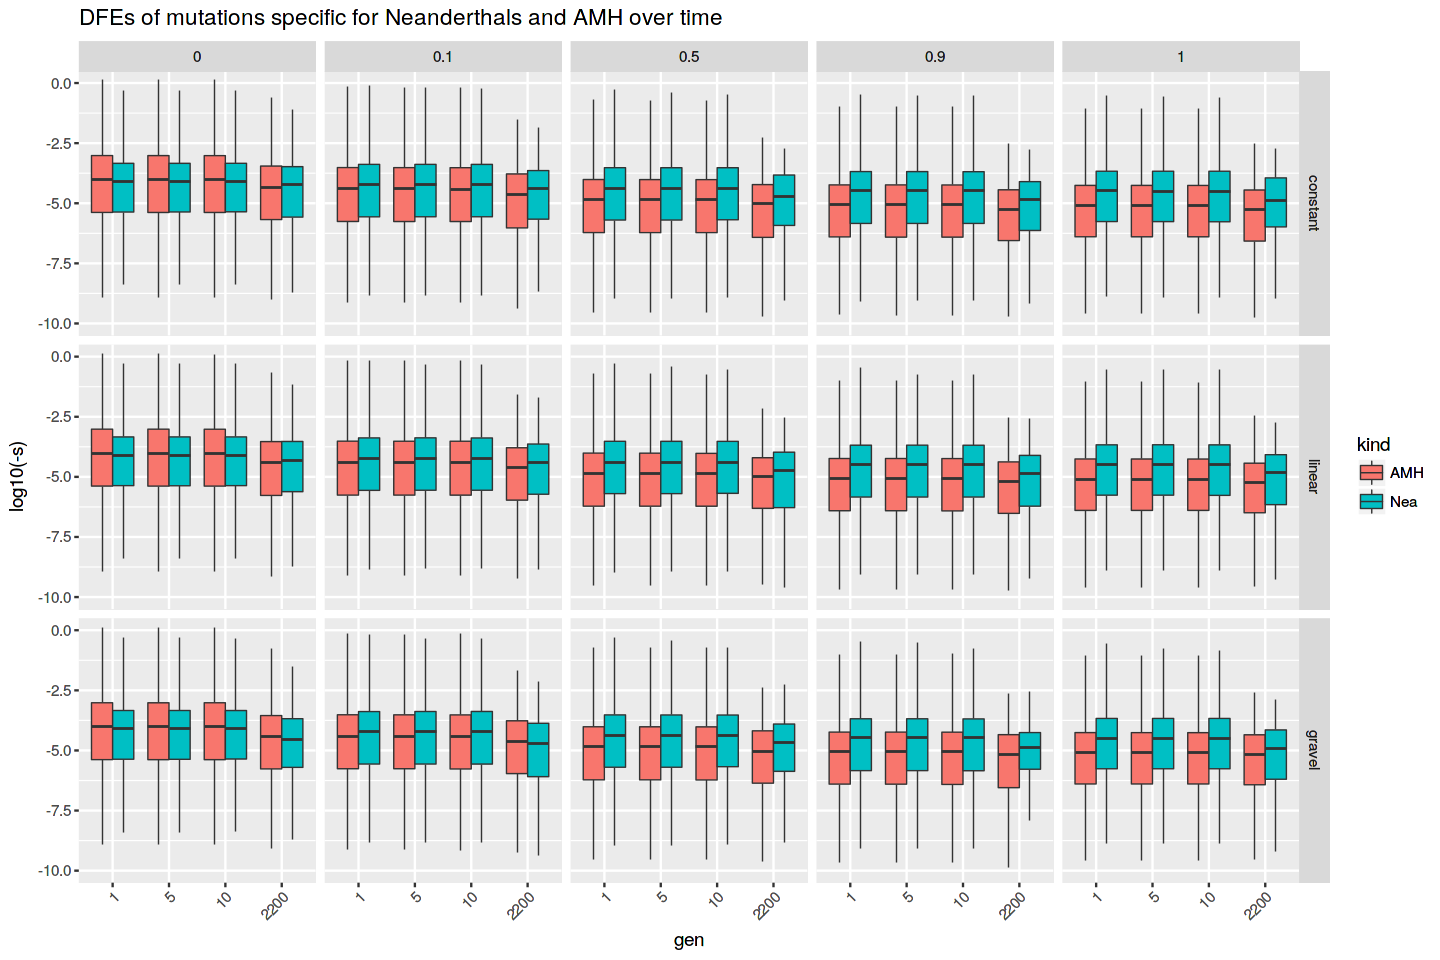

In [40]:
filter(mutations, gen %in% c(1, 5, 10, 2200)) %>%
ggplot() +
    geom_boxplot(aes(x=gen, y=log10(-s), fill=kind, weight=freq), size=0.3, outlier.size=NA) +
    facet_grid(model ~ h) +
    coord_cartesian(ylim=c(0, -10)) +
    labs(title="DFEs of mutations specific for Neanderthals and AMH over time") +
    theme(axis.text.x = element_text(angle=45, hjust=1))